<a href="https://colab.research.google.com/github/daost2001/X-ray-image-classification/blob/main/VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Retrieving dataset

---



In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload() #get api token from kaggle and upload kaggle.json file

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"daost2001","key":"a5df988defe86b3aaee106b673362bc9"}'}

In [ ]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


rm: cannot remove '/root/.kaggle': No such file or directory


In [ ]:
!kaggle datasets download paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:19<00:00, 120MB/s]
100% 2.29G/2.29G [00:19<00:00, 125MB/s]


In [ ]:
! unzip chest-xray-pneumonia.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

# Image preprocessing

retrieve training set

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Convolution2D,MaxPooling2D,Flatten 
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
IMAGE_SIZE = 128

#training set
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,
        vertical_flip=True,
        horizontal_flip=True,
        brightness_range=(1,1.3)
)
train_generator = train_datagen.flow_from_directory(
        'chest_xray/chest_xray/train',
        target_size=(IMAGE_SIZE,IMAGE_SIZE),
        class_mode="sparse",
)

Found 5216 images belonging to 2 classes.


In [ ]:
class_names = list(train_generator.class_indices.keys())
class_names

['NORMAL', 'PNEUMONIA']

retrieve test set

In [ ]:
#testing set
test_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,
        vertical_flip=True,
        horizontal_flip=True,
        brightness_range=(1,1.3)
)

test_generator = test_datagen.flow_from_directory(
        'chest_xray/chest_xray/test',
        target_size=(IMAGE_SIZE,IMAGE_SIZE),
        class_mode="sparse"
)

Found 624 images belonging to 2 classes.


Calculate class weights to account for data imbalance

In [ ]:
import os
dir_path = r'chest_xray/chest_xray/train/PNEUMONIA'
PNEUMONIA_count = 0
# Iterate directory
for path in os.listdir(dir_path):
    if os.path.isfile(os.path.join(dir_path, path)):
        PNEUMONIA_count += 1
dir_path = r'chest_xray/chest_xray/train/NORMAL'
NORMAL_count = 0
# Iterate directory
for path in os.listdir(dir_path):
    if os.path.isfile(os.path.join(dir_path, path)):
        NORMAL_count += 1
TRAIN_count =  PNEUMONIA_count + NORMAL_count

print("Normal images count in training set: " + str(NORMAL_count))

print("Pneumonia images count in training set: " + str(PNEUMONIA_count))

Normal images count in training set: 1342
Pneumonia images count in training set: 3876


In [ ]:
import numpy as np
weight_for_0 = (1 / NORMAL_count)*(TRAIN_count)/2.0 
weight_for_1 = (1 / PNEUMONIA_count)*(TRAIN_count)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.94
Weight for class 1: 0.67


# Initial sequential model

In [ ]:
sz = 128

# Initializing the CNN
model = Sequential()

model.add(keras.layers.experimental.preprocessing.Rescaling(1./255,input_shape = (sz,sz,3)))
model.add(Convolution2D(16,3, padding ='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Convolution2D(32,3, padding ='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Convolution2D(64,3, padding ='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Convolution2D(128,3, padding ='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

# Adding a fully connected layer
model.add(Dense(units=96, activation='relu'))
model.add(Dropout(0.50))
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.50))
model.add(Dense(units=2, activation='softmax'))

using transfer learning with VGG16

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model

vgg_model = VGG16(include_top=False, input_shape=(128, 128, 3))

for layer in vgg_model.layers:
    layer.trainable=False

flat1 = Flatten()(vgg_model.layers[-1].output)
class1 = Dense(256, activation='relu')(flat1)
output = Dense(3, activation='sigmoid')(class1)

model = Model(inputs = vgg_model.inputs, outputs = output)

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [ ]:
model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

training the model

In [ ]:
history = model.fit(
    train_generator,
    validation_data=test_generator,
    steps_per_epoch=50,
    epochs=30,
    class_weight=class_weight,
)

Epoch 1/30
50/50 [==============================] - 405s 8s/step - loss: 0.6223 - accuracy: 0.7781 - val_loss: 0.4080 - val_accuracy: 0.8237
Epoch 2/30
50/50 [==============================] - 402s 8s/step - loss: 0.1813 - accuracy: 0.9256 - val_loss: 0.5206 - val_accuracy: 0.7853
Epoch 3/30
50/50 [==============================] - 401s 8s/step - loss: 0.1492 - accuracy: 0.9450 - val_loss: 0.3034 - val_accuracy: 0.8814
Epoch 4/30
50/50 [==============================] - 416s 8s/step - loss: 0.1523 - accuracy: 0.9375 - val_loss: 0.3899 - val_accuracy: 0.8638
Epoch 5/30
50/50 [==============================] - 400s 8s/step - loss: 0.1458 - accuracy: 0.9406 - val_loss: 0.5145 - val_accuracy: 0.8285
Epoch 6/30
50/50 [==============================] - 403s 8s/step - loss: 0.1472 - accuracy: 0.9425 - val_loss: 0.4207 - val_accuracy: 0.8446
Epoch 7/30
50/50 [==============================] - 400s 8s/step - loss: 0.1159 - accuracy: 0.9513 - val_loss: 0.6719 - val_accuracy: 0.7869
Epoch 8/30
50

In [ ]:
scores = model.evaluate(test_generator)

20/20 [==============================] - 111s 6s/step - loss: 0.4977 - accuracy: 0.8446


In [ ]:
scores

[0.4977174401283264, 0.8445512652397156]

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

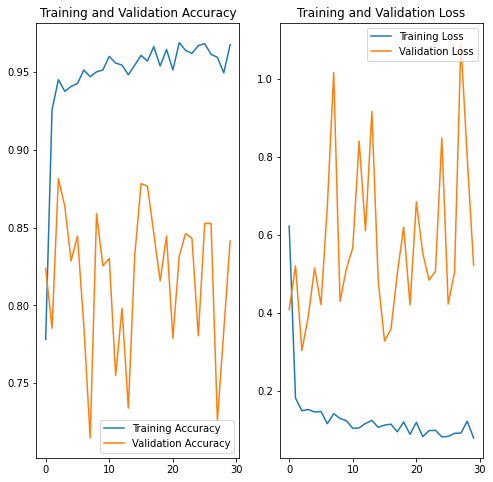

In [ ]:
import matplotlib.pyplot as plt
EPOCHS = 30

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Refining the model

In [ ]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True) #early stopping point if no more improvement

In [ ]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn) #learning rate callback

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=50,
    epochs=30,
    validation_data=test_generator,
    class_weight=class_weight,
    callbacks=[early_stopping_cb, lr_scheduler]
)

Epoch 1/30
50/50 [==============================] - 402s 8s/step - loss: 0.6686 - accuracy: 0.8238 - val_loss: 1.1993 - val_accuracy: 0.6106 - lr: 0.0100
Epoch 2/30
50/50 [==============================] - 399s 8s/step - loss: 0.3048 - accuracy: 0.9019 - val_loss: 0.3118 - val_accuracy: 0.8718 - lr: 0.0089
Epoch 3/30
50/50 [==============================] - 400s 8s/step - loss: 0.1894 - accuracy: 0.9287 - val_loss: 0.4459 - val_accuracy: 0.8413 - lr: 0.0079
Epoch 4/30
50/50 [==============================] - 400s 8s/step - loss: 0.1406 - accuracy: 0.9475 - val_loss: 0.6063 - val_accuracy: 0.7772 - lr: 0.0071
Epoch 5/30
50/50 [==============================] - 400s 8s/step - loss: 0.1237 - accuracy: 0.9556 - val_loss: 0.4040 - val_accuracy: 0.8638 - lr: 0.0063
Epoch 6/30
50/50 [==============================] - 399s 8s/step - loss: 0.1591 - accuracy: 0.9381 - val_loss: 0.3177 - val_accuracy: 0.8718 - lr: 0.0056
Epoch 7/30
50/50 [==============================] - 400s 8s/step - loss: 0.1

In [ ]:
scores = model.evaluate(test_generator)


20/20 [==============================] - 112s 6s/step - loss: 0.3641 - accuracy: 0.8670


In [ ]:
scores

[0.36413127183914185, 0.8669871687889099]

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

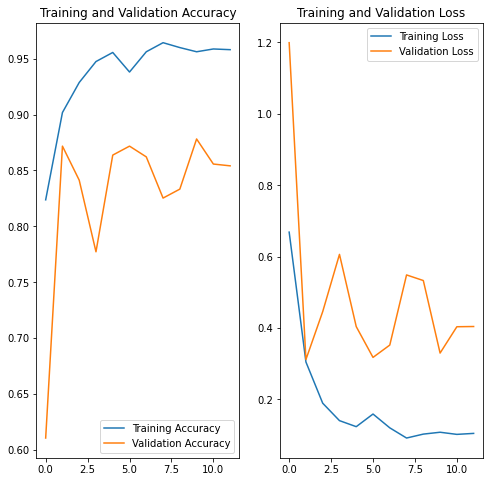

In [ ]:
import matplotlib.pyplot as plt
EPOCHS = 12 #edit according to where early stop ends

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Using model to make predictions

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i])
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

    

1/1 [==============================] - 0s 204ms/step


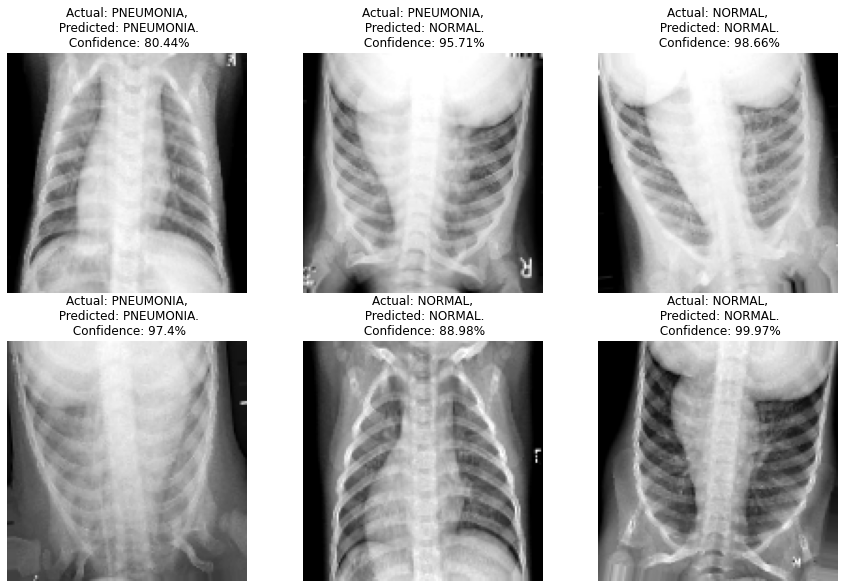

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_generator:
    for i in range(6):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        
        predicted_class, confidence = predict(model, images[i])
        actual_class = class_names[int(labels[i])] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

    break

In [ ]:
from pathlib import Path
import cv2
from keras.utils import to_categorical
from mlxtend.plotting import plot_confusion_matrix

normal_cases_dir = Path("chest_xray/chest_xray/test/NORMAL")
pneumonia_cases_dir = Path("chest_xray/chest_xray/test/PNEUMONIA")

normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

test_data = []
test_labels = []

for img in normal_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (128,128))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(0, num_classes=2)
    test_data.append(img)
    test_labels.append(label)
                      
for img in pneumonia_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (128,128))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(1, num_classes=2)
    test_data.append(img)
    test_labels.append(label)
    

test_data = np.array(test_data)
test_labels = np.array(test_labels)

In [ ]:
preds = model.predict(test_data, batch_size=16)
preds = np.argmax(preds, axis=-1)


39/39 [==============================] - 108s 3s/step


<Figure size 432x288 with 0 Axes>

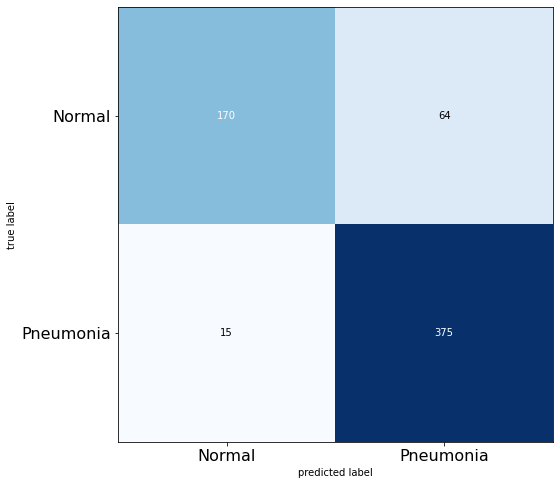

In [ ]:
from sklearn.metrics import confusion_matrix

orig_test_labels = np.argmax(test_labels, axis=-1)

cm  = confusion_matrix(orig_test_labels, preds)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.show()